In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import re
import nltk
nltk.download("stopwords")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
dataset_path = "Twitter_Data.csv"
df = pd.read_csv(dataset_path)

In [5]:
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [6]:
df = df.dropna()

In [7]:
print(df[df["category"] == -1].size)
print(df[df["category"] == 0].size)
print(df[df["category"] == 1].size)

71018
110422
144498


In [10]:
df["clean_text"][10]

'things like demonetisation gst goods and services tax…the upper castes would sort either view favourably say that need give this more time other castes like dalits the muslims were more against because that’ just not modi’ constituency2'

In [12]:
def text_normalize(text):
    """Normalizes text by performing the following steps:
    1. Lowercasing
    2. Removing retweet old acronym "RT"
    3. Removing hyperlinks
    4. Removing punctuation
    5. Removing stopwords

    Args:
        text (str): The text to be normalized.

    Returns:
        str: The normalized text.
    """

    # Lowercasing
    text = text.lower()

    # Retweet old acronym "RT" removal
    text = re.sub(r'^rt[\s]+', '', text)

    # Hyperlinks removal
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    # Punctuation   
    text = re.sub(r'[^\w\s]', '', text)
    
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    
    # Stemming
    stemmer = SnowballStemmer('english')
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    text = ' '.join(words)
    
    return text 

In [13]:
df["clean_text"] = df["clean_text"].apply(text_normalize)

In [14]:
df.head()

,clean_text,category
0,modi promis minimum govern maximum govern expe...,-1.0
1,talk nonsens continu drama vote modi,0.0
2,say vote modi welcom bjp told rahul main campa...,1.0
3,ask support prefix chowkidar name modi great s...,1.0
4,answer among power world leader today trump pu...,1.0


In [15]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['clean_text']).toarray()

In [16]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
intercept = np.ones((X.shape[0], 1))
X_b = np.concatenate(
    (intercept, X),
    axis = 1
)

In [18]:
X_b

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [19]:
n_classes = df['category'].nunique()
n_samples = df['category'].size

In [20]:
y = df['category'].to_numpy() + 1
y = y.astype(np.uint8)
y_encoded = np.array(
    [np.zeros(n_classes) for _ in range(n_samples)]
)
y_encoded[np.arange(n_samples), y] = 1

In [21]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_b, y_encoded, test_size=val_size, random_state=random_state, shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle
)

In [22]:
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / exp_z.sum(axis=1)[:, None]

def predict(X, theta):
    z = np.dot(X, theta)
    y_hat = softmax(z)
    return y_hat

def compute_loss(y_hat, y):
    n = y.size
    return (-1 / n) * np.sum(y * np.log(y_hat))

def compute_gradient(X, y, y_hat):
    n = y.size
    return np.dot(X.T, (y_hat - y)) / n 

def update_theta(theta, gradient, lr):
    return theta - gradient * lr

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta)
    acc = (np.argmax(y_hat, axis=1) == np.argmax(y, axis=1)).mean() 
    
    return acc 

In [23]:
lr = 0.1
epochs = 200
batch_size = X_train.shape[0]
n_features = X_train.shape[1]

np.random.seed(random_state)
theta = np.random.uniform(
    size=(n_features, n_classes)
)

In [24]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []
    
    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i + batch_size]
        y_i = y_train[i:i + batch_size]
        
        y_hat = predict(X_i, theta)
        
        loss = compute_loss(y_hat, y_i)
        
        gradient = compute_gradient(X_i, y_i, y_hat)
        
        theta = update_theta(theta, gradient, lr)
        
        train_batch_losses.append(loss)
        
        acc = compute_accuracy(X_i, y_i, theta)
        train_batch_accs.append(acc)
        
        y_hat_val = predict(X_val, theta)
        val_loss = compute_loss(y_hat_val, y_val)
        val_batch_losses.append(val_loss)
        
        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)
        
    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)
    
    train_losses.append(train_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)
    val_losses.append(val_batch_loss)
    
    print(f"\nEPOCH {epoch + 1}:\tTrainning loss: {train_batch_loss:.3f}\tValidation_loss: {val_batch_loss:.3f}")
    


EPOCH 1:	Trainning loss: 0.379	Validation_loss: 0.379

EPOCH 2:	Trainning loss: 0.379	Validation_loss: 0.378

EPOCH 3:	Trainning loss: 0.378	Validation_loss: 0.378

EPOCH 4:	Trainning loss: 0.378	Validation_loss: 0.378

EPOCH 5:	Trainning loss: 0.378	Validation_loss: 0.377

EPOCH 6:	Trainning loss: 0.377	Validation_loss: 0.377

EPOCH 7:	Trainning loss: 0.377	Validation_loss: 0.377

EPOCH 8:	Trainning loss: 0.377	Validation_loss: 0.376

EPOCH 9:	Trainning loss: 0.376	Validation_loss: 0.376

EPOCH 10:	Trainning loss: 0.376	Validation_loss: 0.376

EPOCH 11:	Trainning loss: 0.376	Validation_loss: 0.375

EPOCH 12:	Trainning loss: 0.376	Validation_loss: 0.375

EPOCH 13:	Trainning loss: 0.375	Validation_loss: 0.375

EPOCH 14:	Trainning loss: 0.375	Validation_loss: 0.375

EPOCH 15:	Trainning loss: 0.375	Validation_loss: 0.374

EPOCH 16:	Trainning loss: 0.374	Validation_loss: 0.374

EPOCH 17:	Trainning loss: 0.374	Validation_loss: 0.374

EPOCH 18:	Trainning loss: 0.374	Validation_loss: 0.374



[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

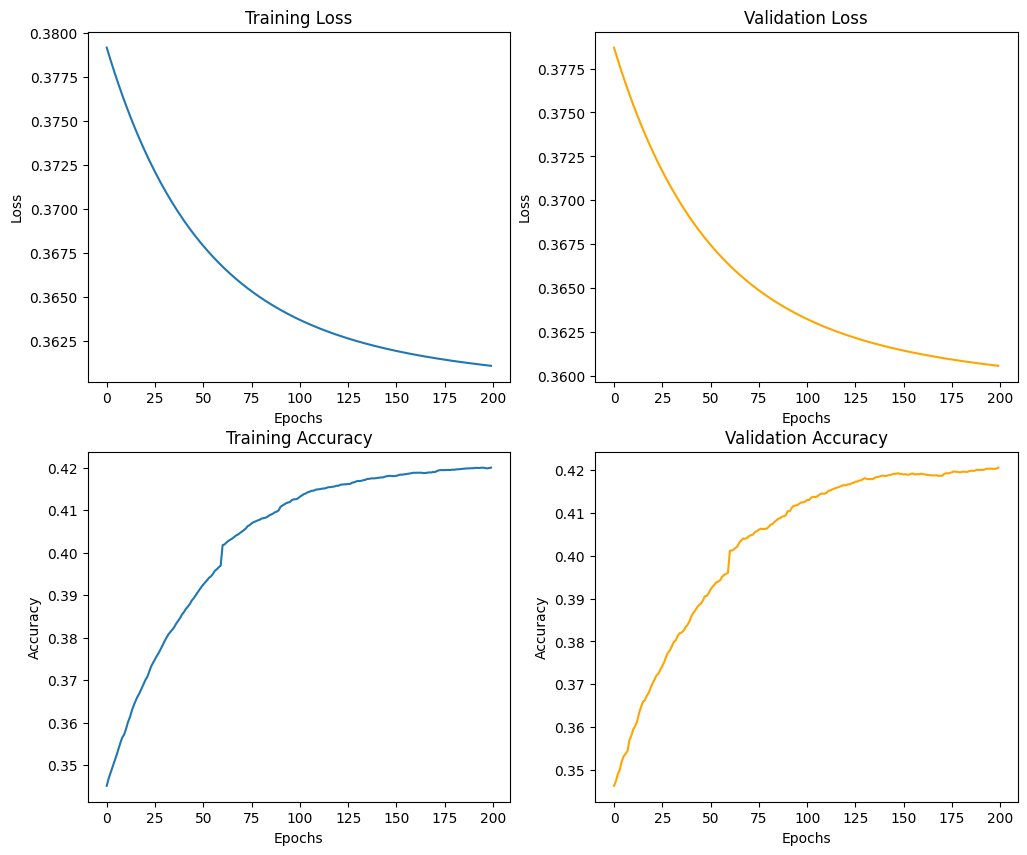

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set_title("Training Loss")
ax[0, 0].set(xlabel="Epochs", ylabel="Loss")

ax[0, 1].plot(val_losses, "orange")
ax[0, 1].set_title("Validation Loss")
ax[0, 1].set(xlabel="Epochs", ylabel="Loss")

ax[1, 0].plot(train_accs)
ax[1, 0].set_title("Training Accuracy")
ax[1, 0].set(xlabel="Epochs", ylabel="Accuracy")

ax[1, 1].plot(val_accs, "orange")
ax[1, 1].set_title("Validation Accuracy")
ax[1, 1].set(xlabel="Epochs", ylabel="Accuracy")

In [26]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)
print("Evaluation on Val set and Test Set:")
print(f"Accuracy on valid set: {val_set_acc}")
print(f"Accuracy on test set: {test_set_acc}")

Evaluation on Val set and Test Set:
Accuracy on valid set: 0.42059888323004235
Accuracy on test set: 0.4190341780695834


# Testing

In [31]:
y_hat = np.array([0.4, 0.15, 0.05, 0.4])
y = np.array([1, 0, 0, 0])

print(compute_loss(y_hat, y) * 4)

0.916290731874155


In [33]:
z = np.array([-1, -2, 3, 2])
for x in z:
    print(np.exp(x) / np.exp(z).sum())

0.013148973089827489
0.00483723687226407
0.7179096055401774
0.26410418449773104


In [36]:
y_hat = [0, 1, 3, 2, 0, 2, 1, 2]
y = [0, 0, 3, 2, 1, 2, 2, 1]

acc = (np.array(y_hat) == np.array(y)).mean()
print(acc)

0.5
